In [10]:
!pip install faiss-cpu

In [2]:
import faiss
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32')
y = mnist.target.astype('int')
X /= 255.0  # Normalize the data
X_train = X
y_train = y
X_test = X[-1:]
y_test = y[-1:]

In [3]:
X_train.values[0].shape

(784,)

In [3]:
def initFlatIndex():
    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train.values)
    return index

def initHNSWIndex(m):
    index = faiss.IndexHNSWFlat(X_train.shape[1], m)
    index.add(X_train)
    return index

def initIVFIndex(nlist, nprobe):
    quantizer = faiss.IndexFlatL2(X_train.shape[1])
    index = faiss.IndexIVFFlat(quantizer, X_train.shape[1], nlist)
    index.nprobe = nprobe
    index.train(X_train)
    index.add(X_train)
    return index

def initLSHIndex(nbits):
    index = faiss.IndexLSH(X_train.shape[1], nbits)
    index.add(X_train)
    return index

In [4]:
def benchmark_faiss(index, X_train, X_test, k=3):
    start_time = time.time()
    D, I = index.search(X_test, k)
    search_time = time.time() - start_time
    return I, search_time


In [26]:
index_configs = {
    'Flat': [(),(),()],
    'HNSW': [(16,), (32,), (64,)],
    'IVF': [(50, 10), (100, 10), (200, 10)],
    'LSH': [(8,), (16,), (32,)]
}

In [5]:
flat_index = initFlatIndex()
flat_indices, _ = benchmark_faiss(flat_index, X_train, X_test)

In [35]:
# results = {index_type: {'times': [], 'accuracies': []} for index_type in index_configs}
results = {index_type: {'configs': [], 'times': [], 'accuracies': []} for index_type in index_configs}

In [36]:
for index_type, configs in index_configs.items():
    for config in configs:
        print(f"Benchmarking {index_type} Index with config {config}...")
        if index_type == 'Flat':
            index = flat_index  # Re-use the FlatIndex
        elif index_type == 'HNSW':
            index = initHNSWIndex(*config)
        elif index_type == 'IVF':
            index = initIVFIndex(*config)
        elif index_type == 'LSH':
            index = initLSHIndex(*config)
        
        faiss_indices, search_time = benchmark_faiss(index, X_train, X_test)
        
        # Calculate accuracy
        correct_matches = np.sum([len(np.intersect1d(faiss_indices[i], flat_indices[i])) for i in range(len(X_test))])
        accuracy = correct_matches / (X_test.shape[0] * 3)
        
        results[index_type]['configs'].append(config)
        results[index_type]['times'].append(search_time)
        results[index_type]['accuracies'].append(accuracy)

Benchmarking Flat Index with config ()...
Benchmarking Flat Index with config ()...
Benchmarking Flat Index with config ()...
Benchmarking HNSW Index with config (16,)...
Benchmarking HNSW Index with config (32,)...
Benchmarking HNSW Index with config (64,)...
Benchmarking IVF Index with config (50, 10)...
Benchmarking IVF Index with config (100, 10)...
Benchmarking IVF Index with config (200, 10)...
Benchmarking LSH Index with config (8,)...
Benchmarking LSH Index with config (16,)...
Benchmarking LSH Index with config (32,)...


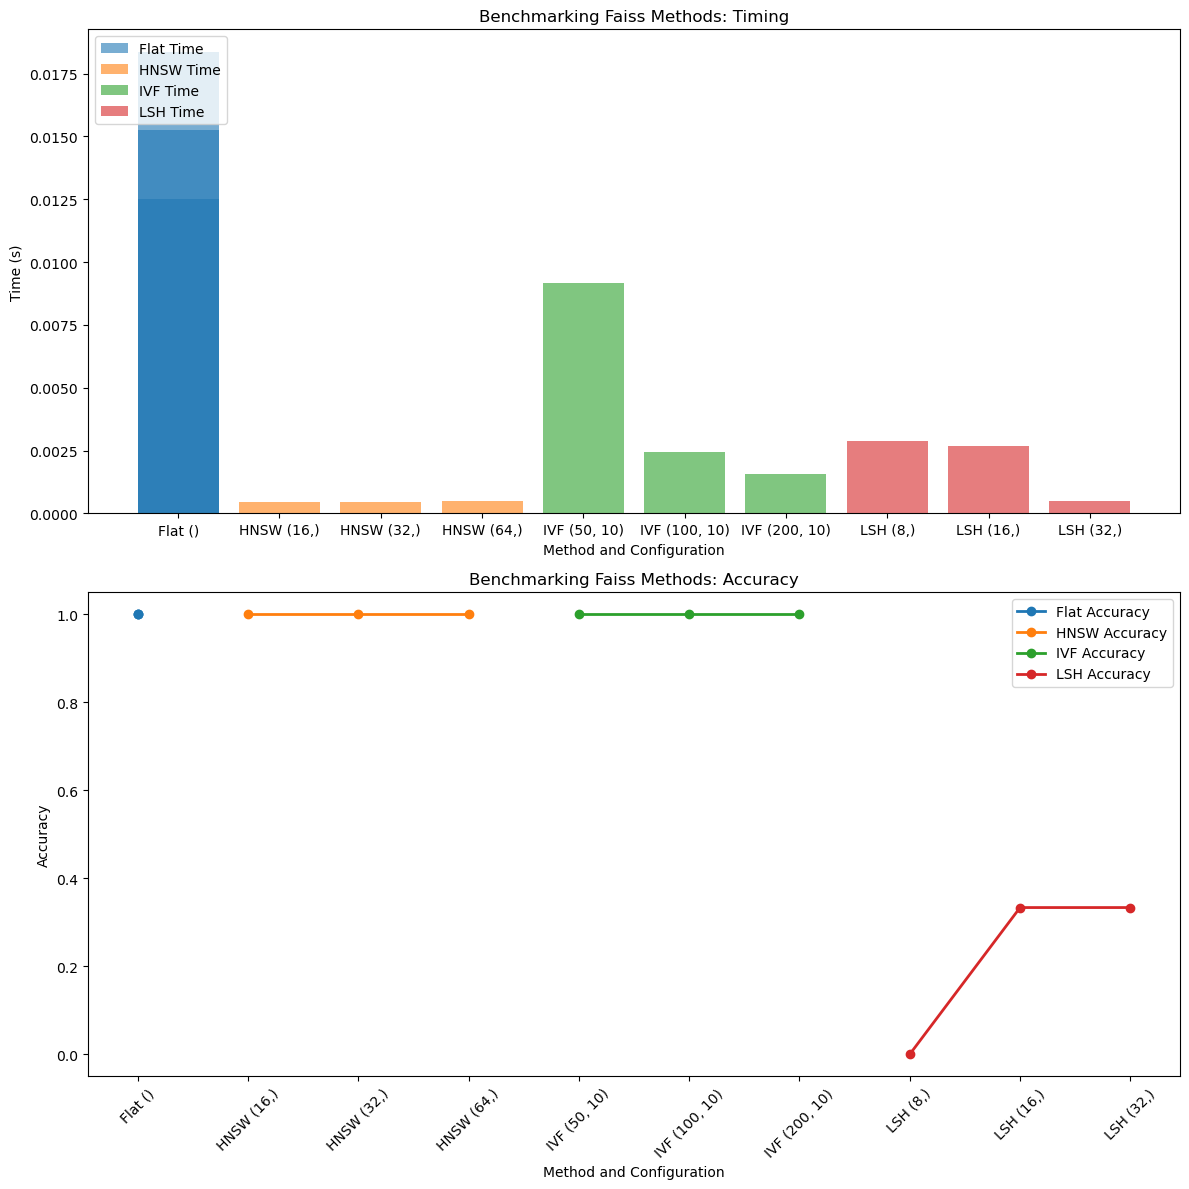

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

methods = list(results.keys())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plotting timing
for i, method in enumerate(methods):
    axs[0].bar([f"{method} {config}" for config in results[method]['configs']], results[method]['times'], color=colors[i], alpha=0.6, label=f'{method} Time')

axs[0].set_xlabel('Method and Configuration')
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')
axs[0].set_title('Benchmarking Faiss Methods: Timing')

# Plotting accuracy
for i, method in enumerate(methods):
    axs[1].plot([f"{method} {config}" for config in results[method]['configs']], results[method]['accuracies'], color=colors[i], marker='o', linestyle='-', linewidth=2, label=f'{method} Accuracy')

axs[1].set_xlabel('Method and Configuration')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='upper right')
axs[1].set_title('Benchmarking Faiss Methods: Accuracy')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import random
import heapq

In [5]:
class BallTreeNode:
    def __init__(self, points):
        self.points = points
        self.centroid = np.mean(points, axis=0)
        self.radius = max(np.linalg.norm(point - self.centroid) for point in points)
        self.left = None
        self.right = None

def find_farthest_point(points, point):
    distances = np.linalg.norm(points - point, axis=1)
    farthest_point_index = np.argmax(distances)
    return points[farthest_point_index]

def project_point_on_line(point, line_point1, line_point2):
    line_vec = line_point2 - line_point1
    point_vec = point - line_point1
    line_unit_vec = line_vec / np.linalg.norm(line_vec)
    projection_length = np.dot(point_vec, line_unit_vec)
    projection_vec = projection_length * line_unit_vec
    return projection_vec

def build_ball_tree(points, leaf_size):
    if len(points) <= leaf_size:
        return BallTreeNode(points)
    
    # Step 1: Select a random point
    random_point = random.choice(points)
    
    # Step 2: Find the point farthest from this random point
    farthest_point1 = find_farthest_point(points, random_point)
    
    # Step 3: Find the point farthest from the farthest point found in step 2
    farthest_point2 = find_farthest_point(points, farthest_point1)
    
    # Step 4: Project all points onto the line joining the two farthest points
    projections = np.array([np.dot(project_point_on_line(point, farthest_point1, farthest_point2), (farthest_point2 - farthest_point1)) for point in points])
    
    # Step 5: Use the median of the projections to divide the space into two halves
    median_projection = np.median(projections)
    left_points = points[projections <= median_projection]
    right_points = points[projections > median_projection]
    
    # Create a node and recursively build the left and right subtrees
    node = BallTreeNode(points)
    node.left = build_ball_tree(left_points, leaf_size)
    node.right = build_ball_tree(right_points, leaf_size)
    return node

def k_nearest_neighbors(node, query_point, k, heap=None):
    if heap is None:
        heap = []

    distance_to_centroid = np.linalg.norm(query_point - node.centroid)
    
    if len(heap) == k and distance_to_centroid - node.radius > -heap[0][0]:
        return heap

    if len(node.points) <= leaf_size:
        for point in node.points:
            distance = np.linalg.norm(query_point - point)
            if len(heap) < k:
                heapq.heappush(heap, (-distance, point))
            else:
                heapq.heappushpop(heap, (-distance, point))
        return heap

    children = [(node.left, np.linalg.norm(query_point - node.left.centroid)) if node.left else None,
                (node.right, np.linalg.norm(query_point - node.right.centroid)) if node.right else None]

    children = [child for child in children if child]
    children.sort(key=lambda x: x[1])

    for child, _ in children:
        heap = k_nearest_neighbors(child, query_point, k, heap)

    return heap


In [6]:
points = X.values[0:5000]
leaf_size = 10
ball_tree = build_ball_tree(points, leaf_size)


In [19]:
times = []
for _ in range(5):
    k=3
    start_time = time.time()
    ball_tree_heap = k_nearest_neighbors(ball_tree, X.values[5001], k)
    search_time = time.time() - start_time
    times.append(search_time)
t = np.mean(times)
print(t)

0.03456554412841797
